## Meet Agrawal - BT19CSE004

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

## Q1 
Develop a function to implement Harris corners detection algorithm. Use the function to detect corner 
points in the given corner_test.png image. Compare your function implementation result with built in 
cv2.cornerHarris() / detectHarrisFeatures() function result to test your code

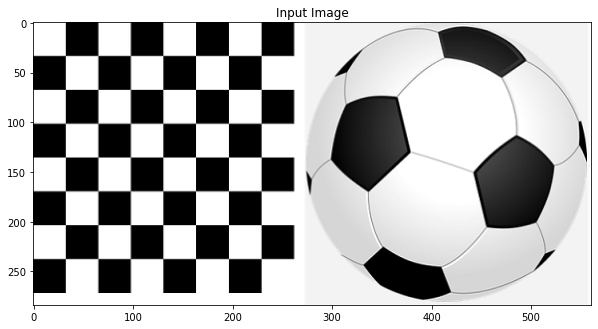

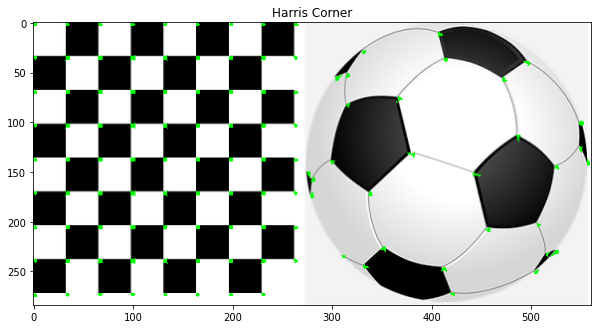

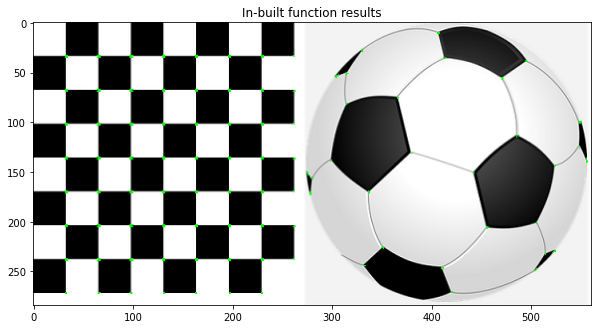

In [3]:
def apply_filter(img,kernel):
    
    # getting size of image
    width,height=img.shape[:2]
    
    # getting size of kernel
    size_x, size_y = kernel.shape[:2]

    # forming an output array of zeros
    output_array = np.zeros((width,height),dtype = 'float64')
    
    # padding the image
    img = np.pad(img, pad_width= ([size_x, ], [size_y, ]),mode= 'constant', constant_values= (0, 0))
        
    for x in range(width): 
        for y in range(height):
            
            # capturing a window to apply the filter
            window = img[x:x + size_x, y:y + size_y]
            
            # scalar product and calculating the sum
            output_values = np.sum(kernel * window, axis=(0, 1)) 
            
            # placing the value to the output array
            output_array[x, y] = output_values
               
    return output_array



def find_harris_corners(input_img):
    
    # defining the kernel for sobel filter in x and y
    sobel_kernel_x = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    sobel_kernel_y = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])

    
    # obtaining image derivatives in x and y directions
    dx = apply_filter(input_img,sobel_kernel_x)
    dy = apply_filter(input_img,sobel_kernel_y)
    

    Ixx = dx**2
    Ixy = dy*dx
    Iyy = dy**2
    
    
    corner_list = []
    
    k = 0.04
    
    window_size = 3
    
    # threshold for the score values to determine if the window contains a valid corner or not
    threshold = 1000000100.00
    
    offset = int(window_size/2)
    y_range = input_img.shape[0] - offset
    x_range = input_img.shape[1] - offset
    
    
    # points to be plotted on the RGB image
    output_img = cv2.cvtColor(input_img.copy(), cv2.COLOR_GRAY2RGB)
    
    
    for y in range(offset, y_range):
        for x in range(offset, x_range):
            
            # positions of our window
            start_y = y - offset
            end_y = y + offset + 1
            start_x = x - offset
            end_x = x + offset + 1
            
            #The variable names are representative to 
            #the variable of the Harris corner equation
            window_Ixx = Ixx[start_y : end_y, start_x : end_x]
            window_Ixy = Ixy[start_y : end_y, start_x : end_x]
            window_Iyy = Iyy[start_y : end_y, start_x : end_x]
            
            #Sum of intensities of partial derivatives in the window
            S_xx = window_Ixx.sum()
            S_xy = window_Ixy.sum()
            S_yy = window_Iyy.sum()

            #Calculate determinant and trace of the window
            determinant = (S_xx * S_yy) - (S_xy**2)
            trace = S_xx + S_yy
            
            # Calculate r for Harris Corner equation
            # r is the score value for a window point
            
            r = determinant - k*(trace**2)

            if r > threshold:
                corner_list.append([x, y, r])
                output_img[y,x] = (0,255,0)
    
    return corner_list, output_img 

    
    
# reading the input image
input_img = cv2.imread('corner_test.png',0)

# display input image
plt.figure(figsize=(10,10))
plt.title('Input Image')
plt.imshow(input_img,cmap='gray')
plt.show()

    
if input_img is not None:
    corner_list, corner_img = find_harris_corners(input_img)
    
    # plot the final image with corners marked
    plt.figure(figsize=(10,10))
    plt.title('Harris Corner')
    plt.imshow(corner_img,cmap='gray')
    plt.show()
else:
    print ("Error in input image!")
            

# inbuilt methods

src = cv2.imread('corner_test.png')
gray = cv2.cvtColor(src,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)
src[dst>0.01*dst.max()]=[0,255,0]

plt.figure(figsize=(10,10))
plt.title('In-built function results')
plt.imshow(src,cmap='gray')
plt.show()


## Q2
Implement your own program to detect lines in a given image using the given hough transform algorithm. 
Use roadlane.jpg to test your code. Compare your code output with inbuilt hough line model fitting function.


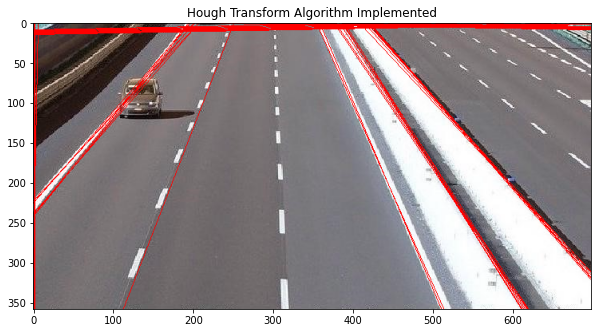

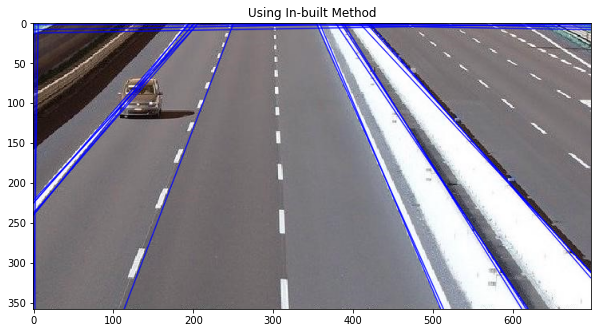

In [2]:
def apply_filter(img,kernel):
    
    # getting size of image
    width,height=img.shape[:2]
    
    # getting size of kernel
    size_x, size_y = kernel.shape[:2]

    # forming an output array of zeros
    output_array = np.zeros((width,height),dtype = 'float32')
    
    # padding the image
    img = np.pad(img, pad_width= ([size_x, ], [size_y, ]),mode= 'constant', constant_values= (0, 0))
        
    for x in range(width): 
        for y in range(height):
            
            # capturing a window to apply the filter
            window = img[x:x + size_x, y:y + size_y]
            
            # scalar product and calculating the sum
            output_values = np.sum(kernel * window, axis=(0, 1)) 
            
            # placing the value to the output array
            output_array[x, y] = output_values
               
    return output_array


def hough_transform(edge):
    
    # Theta 0 - 360 degree
    theta = np.arange(0, 360, 1)
    cos = np.cos(np.deg2rad(theta))
    sin = np.sin(np.deg2rad(theta))

    # Generate a accumulator matrix to store the values
    # getting diagonal length for the matrix
    # range of rho values is 0 to 2*(length_of_diagonal)
    rho_range = round(math.sqrt(edge.shape[0]**2 + edge.shape[1]**2))
    
    
    acc = np.zeros((2 * rho_range, len(theta)), dtype=np.uint8)

    # Determining locations of edges pixels
    edge_pixels = np.where(edge == 255)
    coordinates = list(zip(edge_pixels[0], edge_pixels[1]))

    # rho value calculated for each edge location with all the theta values in the range
    for p in range(len(coordinates)):
        for t in range(len(theta)):
            
            # rho = xcos(theta) + ysin(theta)
            rho = int(round(coordinates[p][1] * cos[t] + coordinates[p][0] * sin[t]))
            acc[rho, t] += 1 # Add vote for rho and theta value

    return acc



image = cv2.imread('roadlane.jpg')
img = cv2.imread('roadlane.jpg',0)



#sobel filter
sobel_kernel_x = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
sobel_kernel_y = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])



i_x = apply_filter(img,sobel_kernel_x)
i_y = apply_filter(img,sobel_kernel_y)

sobel = np.sqrt(i_x**2 + i_y**2)

# scaling the matrix values to be from 0 to 255
sobel-=np.min(sobel)
sobel*=((255.0)/np.max(sobel))



# thresholding on the sobel image for getting edge pixels
edges = np.zeros((sobel.shape[:2][0],sobel.shape[:2][1]),dtype = 'uint8')
edges[sobel>90] = 255


# calculating the accumulator
accumulator = hough_transform(edges)


# thresholding on the votes given to values of rho and theta
edge_pixels = np.where(accumulator > 120)


coordinates = list(zip(edge_pixels[0], edge_pixels[1]))


# Use line equation to draw detected line on an original image
for i in range(0, len(coordinates)):
    a = np.cos(np.deg2rad(coordinates[i][1]))
    b = np.sin(np.deg2rad(coordinates[i][1]))    
    x0 = a*coordinates[i][0]
    y0 = b*coordinates[i][0]
    
    # getting co-ordinates to draw a line
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    cv2.line(image,pt1,pt2,(255,0,0),1)
  

    # display the final image
plt.figure(figsize=(10,10))
plt.title('Hough Transform Algorithm Implemented')
plt.imshow(image,cmap='gray')
plt.show()

    



    
    

# inbuilt method
src = cv2.imread('roadlane.jpg')

#  Standard Hough Line Transform
lines = cv2.HoughLines(edges, 1, np.pi / 180, 120, None, 0, 0)


# Draw the lines
if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv2.line(src, pt1, pt2, (0,0,255), 1, cv2.LINE_AA)

plt.figure(figsize=(10,10))
plt.title('Using In-built Method')
plt.imshow(src,cmap='gray')
plt.show()


## Q4
Write a program to perform image stitching for two images. Use SIFT features (use builtin library 
function) and homography based Feature Matching technique. Use scene1.jpg and scene2.jpg to test the 
program. NOTE: install "pip install opencv-contrib-python" to use builtin SIFT descriptor.
Note: CV2 SIFT function: cv2.xfeatures2d.SIFT_create()
Matlab SIFT function: detectSIFTFeatures()


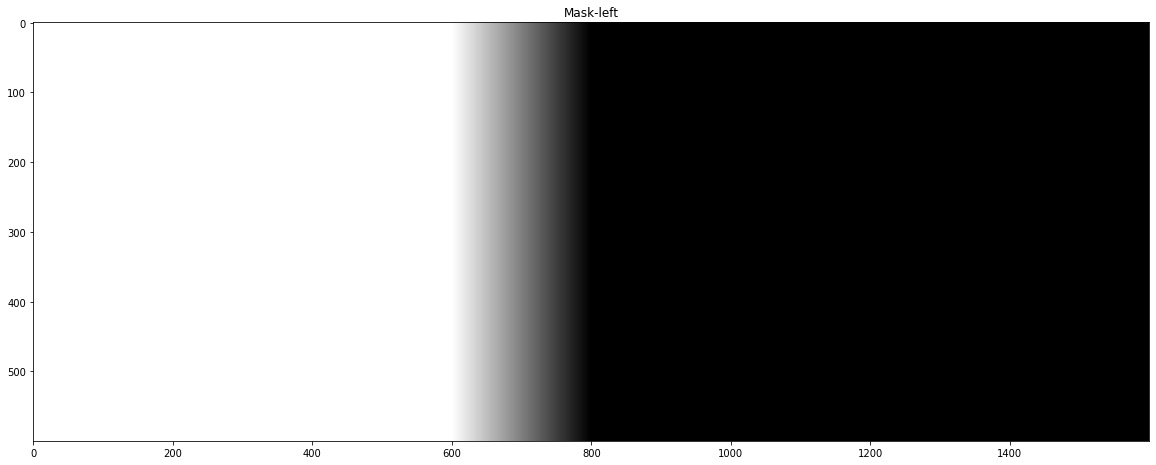

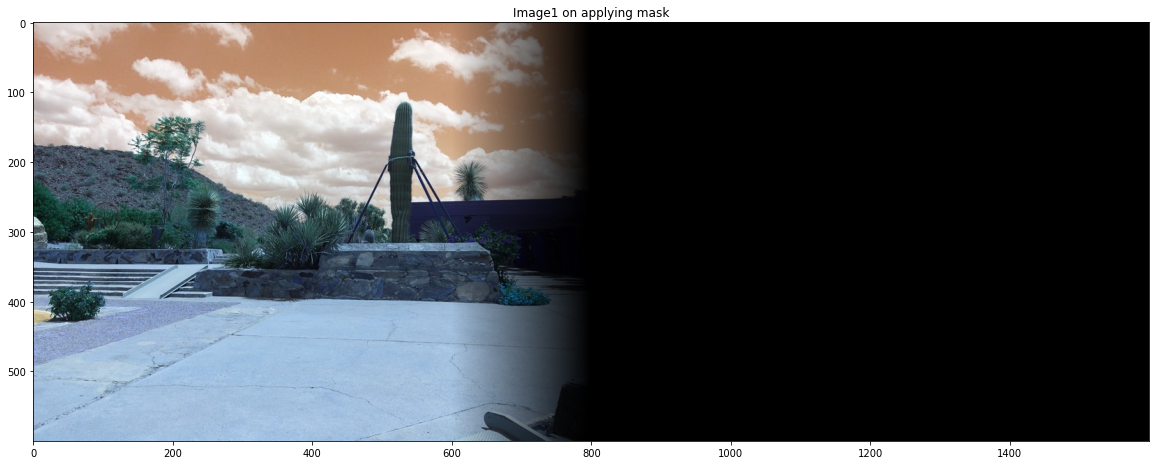

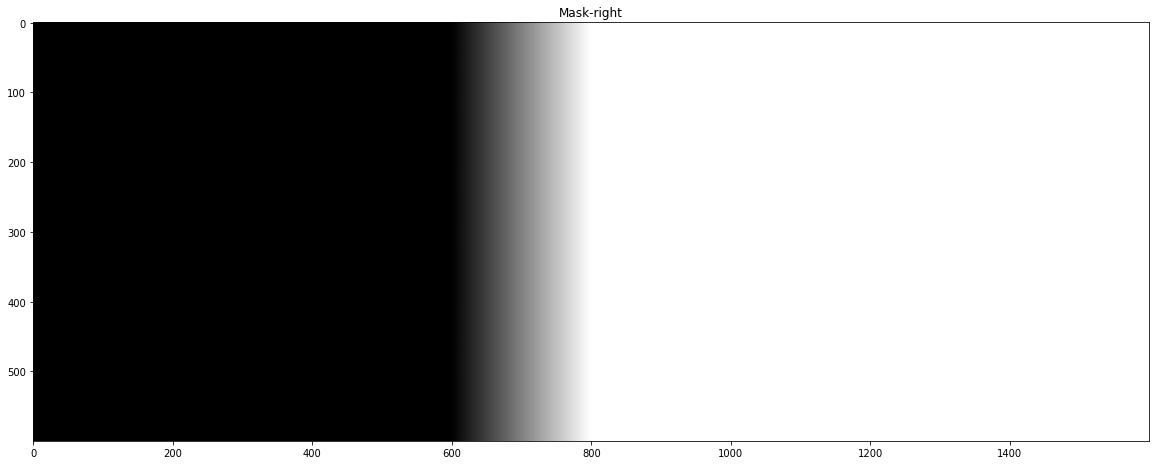

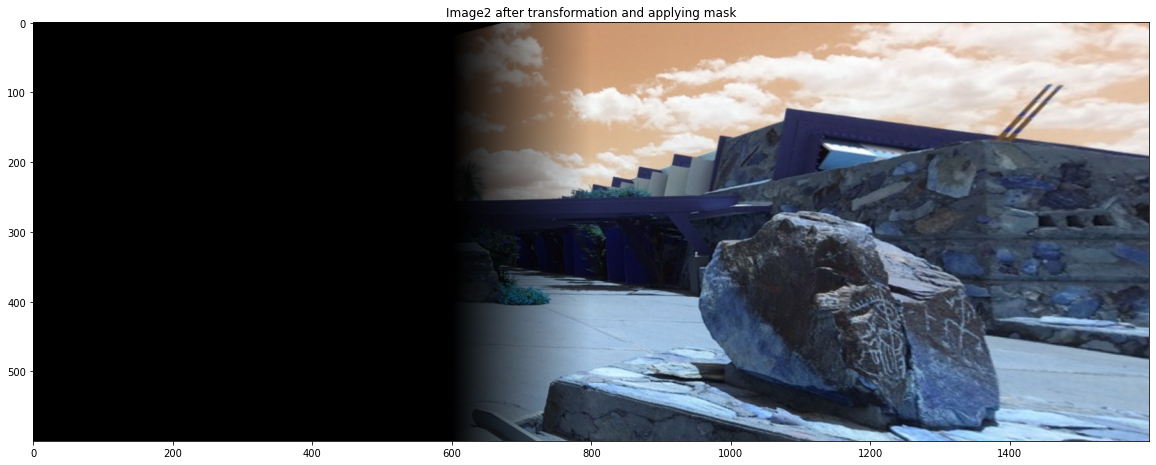

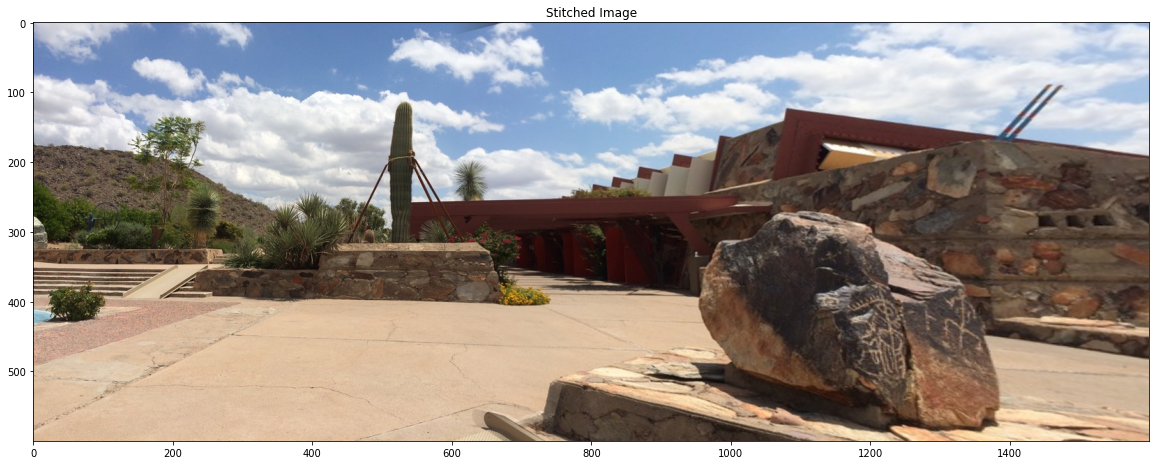

In [6]:
def register_image(img1,img2):
        
    sift=cv2.xfeatures2d.SIFT_create()
    min_match=10
    ratio=0.85
        
    # computing the SIFT features
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)
        
    # using Brute-Force matcher to match these SIFT features
    matcher = cv2.BFMatcher()
    
    # K-Nearest neighbor technique used to match the features
    raw_matches = matcher.knnMatch(des1, des2, k=2)
        
        
    good_points = []
    good_matches=[]
    for m1, m2 in raw_matches:
        if m1.distance < ratio * m2.distance:
            good_points.append((m1.trainIdx, m1.queryIdx))
            good_matches.append([m1])
        
    
    # finding the homograph matrix for transformation    
    # using RANSAC algorithm to find the homograph matrix
    # it will find the perspective transformation of that object
    if len(good_points) > min_match:
        
        image1_kp = np.float32([kp1[i].pt for (_, i) in good_points])
        image2_kp = np.float32([kp2[i].pt for (i, _) in good_points])
        
        H, status = cv2.findHomography(image2_kp, image1_kp, cv2.RANSAC,5.0)
        
    return H

def creating_masks(img1,img2,version):
        
    smoothing_window_size=200
        
    # stiched image height and width calculated
    height_img1 = img1.shape[0]
    width_img1 = img1.shape[1]
    width_img2 = img2.shape[1]
    height_stitchedImage = height_img1
    width_stitchedImage = width_img1 +width_img2
        
        
    offset = int(smoothing_window_size / 2)
    
    # the portion which separates the 
    barrier = img1.shape[1] - int(smoothing_window_size / 2)
    mask = np.zeros((height_stitchedImage, width_stitchedImage))
        
    
    # making relevant masks for the left and the right images
    if version== 'left':
        mask[:, barrier - offset:barrier + offset ] = np.tile(np.linspace(1, 0, 2 * offset ).T, (height_stitchedImage, 1))
        mask[:, :barrier - offset] = 1
        
        plt.figure(figsize=(20,20))
        plt.title('Mask-left')
        plt.imshow(mask,cmap='gray')
        plt.show()
    else:
        mask[:, barrier - offset :barrier + offset ] = np.tile(np.linspace(0, 1, 2 * offset ).T, (height_stitchedImage, 1))
        mask[:, barrier + offset:] = 1
        
        plt.figure(figsize=(20,20))
        plt.title('Mask-right')
        plt.imshow(mask,cmap='gray')
        plt.show()
        
        
    return cv2.merge([mask, mask, mask])

def stitch_images(img1,img2):
    
    
    homograph_matrix = register_image(img1,img2)
        
        
    # stiched image height and width calculated
    height_img1 = img1.shape[0]
    width_img1 = img1.shape[1]
    width_img2 = img2.shape[1]
    height_stitchedImage = height_img1
    
    # width of stitched images will be sum of widths of each image
    width_stitchedImage = width_img1 +width_img2

    
    prep_image1 = np.zeros((height_stitchedImage, width_stitchedImage, 3))
    
    mask1 = creating_masks(img1,img2,version='left')
    prep_image1[0:img1.shape[0], 0:img1.shape[1], :] = img1
    
    # mulitply with mask
    prep_image1 *= mask1
    
    prep_image1-=np.min(prep_image1)
    prep_image1*=((255.0)/np.max(prep_image1))

    # converting type to uint8
    prep_image1 = prep_image1.astype(np.uint8)
    
    plt.figure(figsize=(20,20))
    plt.title('Image1 on applying mask')
    plt.imshow(prep_image1,cmap='gray')
    plt.show()

        
    mask2 = creating_masks(img1,img2,version='right')
    
    # applied warpPerspective to transform image2 using the homography matrix obtained
    prep_image2 = cv2.warpPerspective(img2, homograph_matrix, (width_stitchedImage, height_stitchedImage))*mask2

    prep_image2-=np.min(prep_image2)
    prep_image2*=((255.0)/np.max(prep_image2))

    # converting type to uint8
    prep_image2 = prep_image2.astype(np.uint8)
        
    plt.figure(figsize=(20,20))
    plt.title('Image2 after transformation and applying mask')
    plt.imshow(prep_image2,cmap='gray')
    plt.show()
    
    
    # getting the result by adding both prepared images
    result=prep_image1+prep_image2
    

    
    # ruling out pixels with zero values at the edges of the image to obtain the final image
    # these appear due to applying the mask
    rows, cols = np.where(result[:, :, 0] != 0)
    min_row, max_row = min(rows), max(rows) + 1
    min_col, max_col = min(cols), max(cols) + 1
    final_image = result[min_row:max_row, min_col:max_col, :]
    return final_image


# reading the images
img1 = cv2.imread('scene1.jpg')
img2 = cv2.imread('scene2.jpg')
final= stitch_images(img1,img2)

# convert the image to RGB image from BGR image
final = cv2.cvtColor(final, cv2.COLOR_BGR2RGB)

# display the final image after stitching
plt.figure(figsize=(20,20))
plt.title('Stitched Image')
plt.imshow(final,cmap='gray')
plt.show()

## Q5
Write a program to implement Otsu’s algorithm for global threshold-based image segmentation. Use 
Boat_Otsu.png image to test your code

optimal threshold 134


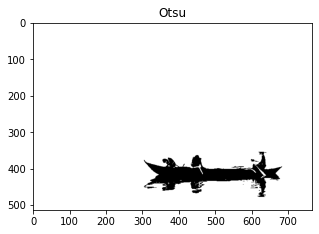

In [9]:
threshold_values = {}
h = [1]


def histogram_calculation(img):
    row, col = img.shape 
    hist = np.zeros(256)
    
    # calculate the number of pixels for each pixel value in the range 0 to 255
    for i in range(0,row):
        for j in range(0,col):
            hist[img[i,j]] += 1
    return hist

   
def count_total_pixels(h):
    cnt = 0
    for i in range(0, len(h)):
        if h[i]>0:
            cnt += h[i]
    return cnt


def calc_weight(low, high):
    total = 0
    for i in range(low, high):
        total += h[i]
    return total


def mean(low, high):
    m = 0
    w = calc_weight(low, high)
    for i in range(low, high):
        m += h[i] * i
    
    return m/float(w)


def variance(low, high):
    v = 0
    m = mean(low, high)
    w = calc_weight(low, high)
    for i in range(low, high):
        v += ((i - m) **2) * h[i]
    v /= w
    return v
            

def find_threshold(h):
    
    # total number of pixels
    cnt = count_total_pixels(h)
    
    
    for i in range(1, len(h)):
        
        var_below = variance(0, i)
        prob_below = calc_weight(0, i) / float(cnt)
        
        var_above = variance(i, len(h))
        prob_above = calc_weight(i, len(h)) / float(cnt)
        
        # within-class variance
        var_within_class = prob_below * (var_below) + prob_above * (var_above)
        
        if not math.isnan(var_within_class):
            threshold_values[i] = var_within_class


def get_optimal_threshold():
    
    min_var_within_class = min(threshold_values.values())

    optimal_threshold = []
    for k,v in threshold_values.items():
        if (v == min_var_within_class):
            optimal_threshold.append(k)
    
    print ('optimal threshold', optimal_threshold[0])
    
    return optimal_threshold[0]


def apply_threshold(img, threshold):
    row, col = img.shape 
    y = np.zeros((row, col))
    for i in range(0,row):
        for j in range(0,col):
            if img[i,j] >= threshold:
                y[i,j] = 255
            else:
                y[i,j] = 0
    return y


# read the image
img = cv2.imread('Boat_Otsu.png',0)

# make the histogram for the input image
h = histogram_calculation(img)

find_threshold(h)

op_thres = get_optimal_threshold()


# apply threshold to the input image
res = apply_threshold(img, op_thres)

# display the final image
plt.figure(figsize=(5,5))
plt.title('Otsu')
plt.imshow(res,cmap='gray')
plt.show()

## Q6
Implement a program to detect moving vehicles by using median differencing background subtraction 
technique and mention your observations on the result. Use traffic.3gp video clip to test your code

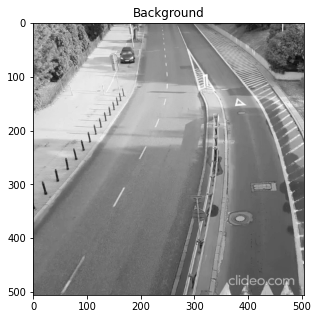

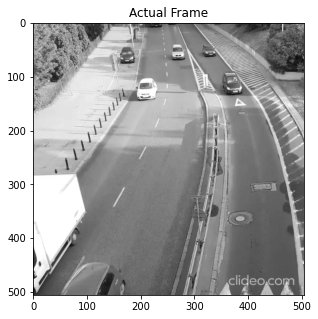

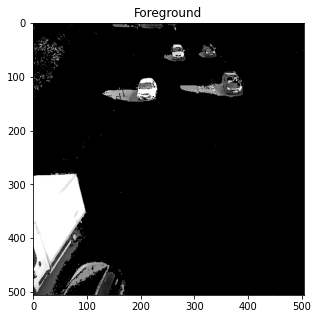

In [10]:
cap = cv2.VideoCapture('traffic.3gp')

frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

buf = np.empty((frameCount, frameHeight, frameWidth, 3), np.dtype('uint8'))

fc = 0
ret = True

while (fc < frameCount  and ret):
    ret, buf[fc] = cap.read()
    fc += 1

cap.release()


images = []

# taking 50 frames to estimate the background
for i in range(50):
    frame = cv2.cvtColor(buf[i],cv2.COLOR_BGR2GRAY)
    images.append(frame)


# background estimation using median
row,col = buf[0].shape[:2]
background = np.zeros([row,col],np.uint8)
background = np.median(images,axis=0)

background = background.astype(np.uint8)

# show the background
plt.figure(figsize=(5,5))
plt.title('Background')
plt.imshow(background,cmap='gray')
plt.show()


img = cv2.cvtColor(buf[50],cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(5,5))
plt.title('Actual Frame')
plt.imshow(img,cmap='gray')
plt.show()

# converting interger 0 and 255 to type uint8
a = np.uint8([255])
b = np.uint8([0])


img = cv2.cvtColor(buf[50],cv2.COLOR_BGR2GRAY)

# creating a mask image to segment out moving objects
res = cv2.absdiff(img,background)
res = np.where(res>20,a,b)

# applying the above 'res' image as a mask 
res = cv2.bitwise_and(img,img,mask=res)


plt.figure(figsize=(5,5))
plt.title('Foreground')
plt.imshow(res,cmap='gray')
plt.show()